In [44]:
import numpy as np
import pandas as pd
import glob
import errno
import os
import random
import spacy
import string
import copy

import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle as pkl
from tqdm import tqdm_notebook
from sklearn.feature_extraction import stop_words

## Load data & Preprocessing

In [2]:
def load_data(files):
    data = []
    for name in files:
        try:
            with open(name) as f:
                for line in f:
                    data.append(line)
        except IOError as exc:
            if exc.errno != errno.EISDIR:
                raise
    return data

In [3]:
path = os.getcwd()+'/aclImdb/train/pos/*.txt'
files = glob.glob(path)
train_pos_data = load_data(files)

In [4]:
path = os.getcwd()+'/aclImdb/train/neg/*.txt'
files = glob.glob(path)
train_neg_data = load_data(files)

In [5]:
path = os.getcwd()+'/aclImdb/test/pos/*.txt'
files = glob.glob(path)
test_pos_data = load_data(files)
path = os.getcwd()+'/aclImdb/test/neg/*.txt'
files = glob.glob(path)
test_neg_data = load_data(files)

In [4]:
len(test_pos_data)

12500

In [6]:
test_data = test_pos_data + test_neg_data
test_targets = ([1] * len(test_pos_data)) + ([0]*len(test_neg_data))

In [7]:
train_split = 10000
train_data = train_pos_data[:train_split] + train_neg_data[:train_split]
train_targets = ([1]*train_split) + ([0]*train_split)

val_data = train_pos_data[train_split:] + train_neg_data[train_split:]
val_targets = ([1]*(len(train_pos_data)-train_split)) + ([0]*(len(train_pos_data)-train_split))

In [194]:
train_data[103]

"While it certainly wasn't the best movie I've ever seen, it was certainly worth the $8 (which can't be said for many movies these days.)<br /><br />This was a pleasant account of a true story, although many of the details of the real story were twisted for the movie, (ie, Billy Sunday's character was three or four people in the real story combined together.) Robert DeNiro was of course good, and Cuba Gooding, Jr., was also impressive."

In [45]:
from sklearn.feature_extraction import stop_words

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(tokens,lower_case,remove_punc,remove_stopwords):
#     tokens = tokenizer(sent)
#     print(lower_case,remove_punc,remove_stopwords)
    tokens = [token.text for token in tokens]
    if lower_case:
        tokens = [token.lower() for token in tokens]
    if remove_punc:
        tokens = [token for token in tokens if (token not in punctuations)]
    if remove_stopwords:
        tokens = [token for token in tokens if (token not in stop_words.ENGLISH_STOP_WORDS)]
    return tokens

In [47]:
from tqdm import tqdm_notebook

def tokenize_dataset(dataset,lower_case,remove_punc,remove_stopwords):
    token_dataset = []
    # we are keeping track of all tokens in dataset
    # in order to create vocabulary later
    all_tokens = []

    for sample in tqdm_notebook(tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
        tokens = tokenize(sample,lower_case,remove_punc,remove_stopwords)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [46]:
# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data,False,False,False)
pkl.dump(val_data_tokens, open("val_none.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data,False,False,False)
pkl.dump(test_data_tokens, open("test_none.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data,False,False,False)
pkl.dump(train_data_tokens, open("train_none.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_none.p", "wb"))

Tokenizing val data


A Jupyter Widget


Tokenizing test data


A Jupyter Widget


Tokenizing train data


A Jupyter Widget

In [48]:
# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data,True,False,False)
pkl.dump(val_data_tokens, open("val_lower.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data,True,False,False)
pkl.dump(test_data_tokens, open("test_lower.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data,True,False,False)
pkl.dump(train_data_tokens, open("train_lower.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_lower.p", "wb"))

Tokenizing val data


A Jupyter Widget


Tokenizing test data


A Jupyter Widget


Tokenizing train data


A Jupyter Widget

In [49]:
# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data,True,True,True)
pkl.dump(val_data_tokens, open("val_lowerpunc_stopw.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data,True,True,True)
pkl.dump(test_data_tokens, open("test_lowerpunc_stopw.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data,True,True,True)
pkl.dump(train_data_tokens, open("train_lowerpunc_stopw.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_lowerpunc_stopw.p", "wb"))

Tokenizing val data


A Jupyter Widget


Tokenizing test data


A Jupyter Widget


Tokenizing train data


A Jupyter Widget

### build ngram

In [263]:
# build n-gram, assume n >= 2
import copy

def build_ngram(n,token_dataset):
    all_n_grams = []
    ngram_dataset = copy.deepcopy(token_dataset)
    for i in range(2,n+1):
        for ind in range(0,len(token_dataset)):
            t = token_dataset[ind]
            for j in range(0,len(t)-(i-1)):
                new_gram = " ".join(t[j:j+i])
                ngram_dataset[ind].append(new_gram)
    for x in ngram_dataset:
        all_n_grams += x
    return ngram_dataset,all_n_grams

In [272]:
n = 4
# val set tokens
print ("Tokenizing val data")
val_ngram, _ = build_ngram(n,val_data_tokens)
pkl.dump(val_ngram, open("val_4gram.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_ngram, _ = build_ngram(n,test_data_tokens)
pkl.dump(test_ngram, open("test_4gram.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_ngram, all_train_ngram = build_ngram(n,train_data_tokens)
pkl.dump(train_ngram, open("train_4gram.p", "wb"))
pkl.dump(all_train_ngram, open("all_train_4gram.p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data


In [270]:
val_ngram[0]

['there',
 'are',
 'enough',
 'sad',
 'stories',
 'about',
 'women',
 'and',
 'their',
 'oppression',
 'by',
 'religious',
 'political',
 'and',
 'societal',
 'means',
 'not',
 'to',
 'diminish',
 'the',
 'films',
 'and',
 'stories',
 'about',
 'genital',
 'mutilation',
 'and',
 'reproductive',
 'rights',
 'as',
 'well',
 'as',
 'wage',
 'inequality',
 'and',
 'marginalization',
 'in',
 'society',
 'all',
 'in',
 'the',
 'name',
 'of',
 'allah',
 'or',
 'god',
 'or',
 'some',
 'other',
 'ridiculous',
 'justification',
 'but',
 'sometimes',
 'it',
 'is',
 'helpful',
 'to',
 'just',
 'take',
 'another',
 'approach',
 'and',
 'shed',
 'some',
 'light',
 'on',
 'the',
 'subject.<br',
 '/><br',
 '/>the',
 'setting',
 'is',
 'the',
 '2006',
 'match',
 'between',
 'iran',
 'and',
 'bahrain',
 'to',
 'qualify',
 'for',
 'the',
 'world',
 'cup',
 'passions',
 'are',
 'high',
 'and',
 'several',
 'women',
 'try',
 'to',
 'disguise',
 'themselves',
 'as',
 'men',
 'to',
 'get',
 'into',
 'the',
 

In [ ]:
train_2gram = pkl.load(open("train_2gram.p", "rb"))
all_train_2gram = pkl.load(open("all_train_2gram.p", "rb"))

val_2gram = pkl.load(open("val_2gram.p", "rb"))
test_2gram = pkl.load(open("test_2gram.p", "rb"))

## Scratch

In [232]:
# load preprocessed train, val and test datasets
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

In [149]:
# len(all_train_tokens)
# len(train_data_tokens)
# train_data_tokens[0]

# plot train dataset
train_lengths = []
for i in range(0,len(train_data_tokens)):
    train_lengths.append(len(train_data_tokens[i]))

In [159]:
count = Counter(train_lengths)

(array([1.4106e+04, 4.2650e+03, 1.1380e+03, 4.0100e+02, 7.9000e+01,
        5.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  10. ,  261.1,  512.2,  763.3, 1014.4, 1265.5, 1516.6, 1767.7,
        2018.8, 2269.9, 2521. ]),
 <a list of 10 Patch objects>)

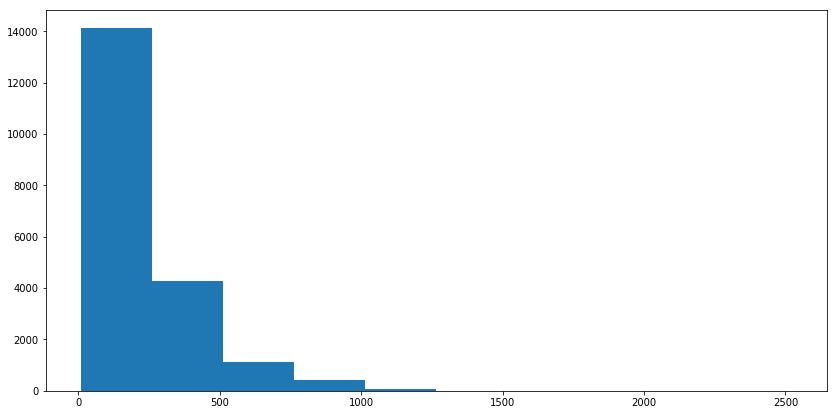

In [180]:
import matplotlib.pyplot as plt
% matplotlib inline

fig = plt.figure(1,figsize = (14,7)) 
# plt.scatter(range(1,len(train_data_tokens)+1),train_lengths, s=3)
plt.hist(sorted(train_lengths),bins=10)
# plt.plot(np.linspace(-1,1,num=1006),sorted(count.values()))
# plt.plot(count.keys(),count.values())

In [182]:
bincount,binedge = np.histogram(train_lengths,bins=10)

In [183]:
sum(bincount)*.90

18000.0

In [184]:
bincount

array([14106,  4265,  1138,   401,    79,     5,     2,     3,     0,
           1])

In [186]:
sum(bincount[:2])

18371

In [185]:
binedge

array([  10. ,  261.1,  512.2,  763.3, 1014.4, 1265.5, 1516.6, 1767.7,
       2018.8, 2269.9, 2521. ])

In [174]:
token_counter = Counter(all_train_tokens)

In [179]:
len(token_counter.keys())
sorted(token_counter.values(),reverse=True)[10000]

26

In [191]:
token_counter['br']

6277

Now, we are going to create the vocabulary of most common 10,000 tokens in the training set.

In [119]:
from collections import Counter

max_vocab_size = 10000
# save index 0 for pad and 1 for unk
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [120]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 7845 ; token hobgoblins
Token hobgoblins; token id 7845


In [126]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


Now we are going to create PyTorch DataLoader 

In [141]:
MAX_SENTENCE_LENGTH = 400

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

# for i, (data, lengths, labels) in enumerate(train_loader):
#     print(data)
#     print(lengths)
#     print(labels)
#     break

In [146]:
for i, (data, lengths, labels) in enumerate(train_loader):
    print(data)
    print(lengths)
    print(labels)
    break

tensor([[   4, 1059, 1410,  ...,    0,    0,    0],
        [  93,   62,   22,  ...,    3,  184,    6],
        [ 256,   25,  115,  ...,    0,    0,    0],
        ...,
        [  29,   44,  115,  ...,    0,    0,    0],
        [  11,    7,    4,  ...,  727,   68, 1681],
        [  10, 1568,   57,  ...,    8, 2683,   92]])
tensor([290, 400, 297,  40, 237,  59, 400, 400, 400, 400,  71, 288, 224, 232,
        351, 156, 400, 119, 264, 400, 400, 400, 117, 186, 156, 385, 136, 127,
        145,  71, 400, 400])
tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 1, 1, 0])


Here we will define Bag-of-Words model in PyTorch

In [142]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

In [143]:
learning_rate = 0.01
num_epochs = 2 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))


Epoch: [1/2], Step: [101/625], Validation Acc: 81.8
Epoch: [1/2], Step: [201/625], Validation Acc: 85.06
Epoch: [1/2], Step: [301/625], Validation Acc: 87.0
Epoch: [1/2], Step: [401/625], Validation Acc: 87.08
Epoch: [1/2], Step: [501/625], Validation Acc: 88.68
Epoch: [1/2], Step: [601/625], Validation Acc: 88.72
Epoch: [2/2], Step: [101/625], Validation Acc: 88.34
Epoch: [2/2], Step: [201/625], Validation Acc: 88.56
Epoch: [2/2], Step: [301/625], Validation Acc: 88.14
Epoch: [2/2], Step: [401/625], Validation Acc: 87.96
Epoch: [2/2], Step: [501/625], Validation Acc: 88.3
Epoch: [2/2], Step: [601/625], Validation Acc: 87.12


In [144]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 2 epochs
Val Acc 87.92
Test Acc 86.392
